In [1]:
from datasets import BitcoinOTC, BitcoinAlpha, AS733, UCIMessage, SBM, StackOverflow, RedditTitle, RedditBody
from dataloader import BitcoinLoaderFactory
import matplotlib.pyplot as plt
import seaborn as sbn
from tqdm import tqdm
import torch
import os
import numpy as np
import pandas as pd
from torch_geometric.datasets import JODIEDataset

datasets = []

datasets.append(BitcoinOTC('./data/bitcoin', transform=None))
datasets.append(BitcoinAlpha('./data/bitcoin', transform=None))
datasets.append(UCIMessage('./data/uci-msg', transform=None))
datasets.append(RedditTitle('./data/reddit', transform=None))
datasets.append(RedditBody('./data/reddit', transform=None))
datasets.append(AS733('./data/as-733', transform=None))
datasets.append(StackOverflow('./data/stackoverflow', transform=None))
datasets.append(SBM('./data/sbm', transform=None))


datanames = [
    'bitcoinalpha', 'bitcoinotc', 'uci', 'redt', 'redb',
    'as733', 'stackoverflow', 'sbm'
]

In [150]:
for ds in datasets:
    nnode2 = ds.num_nodes
    nnz = np.mean([d.edge_index.size(1) / nnode2 for d in ds])
    print(f'{nnz:.2f}')


0.04
0.05
0.36
0.06
0.05
2.12
0.12
97.42


<Axes: >

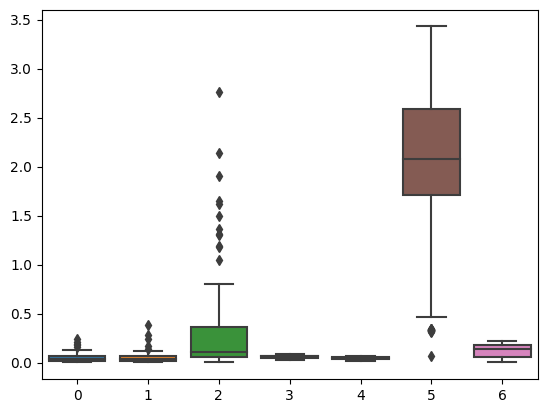

In [2]:
ratio = []
for ds in datasets[:-1]: # sbm ~ 100
    r = []
    for d in ds:
        r.append( len(d.edge_attr) / d.num_nodes )
    ratio.append(r)

sbn.boxplot(ratio)

In [143]:
import os

class ParseExperimentLog():
    def __init__(self):
        pass

    def parse_line(self, line, pos):
        return line.strip().split(' ')[pos]

    def read_file(self, file_path):
        with open(file_path, 'r') as f:
            lines = f.readlines()
            if len(lines) > 48:
                lines = lines[-48:]
            runs = int(self.parse_line(lines[10], -1))
            ds = self.parse_line(lines[1], -1)
            model = self.parse_line(lines[2], -1)
            mini = self.parse_line(lines[32], -1)
            gpu_mem = float(self.parse_line(lines[34], -2))
            epoch_time = float(self.parse_line(lines[36], -2))
            train_time = float(self.parse_line(lines[37], -2))
            mr = 42 + runs
            mean = [float(x.strip()) for x in lines[mr].split('|')[3:7]]
            std  = [float(x.strip()) for x in lines[mr+1].split('|')[3:7]]
            if mini == 'True':
                type = 'mini'
            elif len(file_path.split('.')) > 2:
                type = 'exp'
            else:
                type = 'main'

            exp_name = ''
            exp_param = 0
            if type == 'exp':
                exp_name = file_path.split('.', 1)[1][:-4]
                if exp_name.startswith('window-') or  exp_name.startswith('dropout-') \
                or exp_name.startswith('heads-') or  exp_name.startswith('hidden-') \
                or exp_name.startswith('learnrate-') or  exp_name.startswith('n_neg_train-'):
                    arr = exp_name.split('-')
                    exp_name = arr[0]
                    exp_param = arr[1]
            return {
                'dataset': ds,
                'model': model,
                'gpu_mem': gpu_mem,
                'epoch_time': epoch_time,
                'train_time': train_time,
                'mrr_mean': mean[0],
                'hit@1_mean': mean[1],
                'hit@3_mean': mean[2],
                'hit@10_mean': mean[3],
                'mrr_std': std[0],
                'hit@1_std': std[1],
                'hit@3_std': std[2],
                'hit@10_std': std[3],
                'type': type,
                'exp_name': exp_name,
                'exp_param': float(exp_param),
            }
    
    def read_all(self, log_path='log'):
        records = []
        for file in os.listdir(log_path): 
            if file.endswith(".log"): 
                file_path = f"log/{file}"
                records.append(self.read_file(file_path))
        return pd.DataFrame(records)

parser = ParseExperimentLog()
df = parser.read_all()

In [4]:
df

,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,type,exp_name,exp_param
0,as733,hgcn,2212.59,5.79,268.33,0.4576,0.2963,0.5333,0.7932,0.0014,0.0037,0.0012,0.0045,main,,0.0
1,uci,hgat,146.94,1.13,48.48,0.3095,0.1855,0.3555,0.5540,0.0118,0.0091,0.0123,0.0179,exp,window,14.0
2,redt,gat,1003.40,4.53,54.37,0.1813,0.0552,0.1619,0.4473,0.0034,0.0017,0.0062,0.0058,main,,0.0
3,redb,hgcn,560.99,3.29,57.04,0.2795,0.1454,0.3006,0.6075,0.0066,0.0054,0.0099,0.0036,main,,0.0
4,uci,hgat,131.95,0.85,31.82,0.3101,0.1894,0.3713,0.5167,0.0012,0.0057,0.0028,0.0117,exp,window,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154,uci,hgat,136.75,1.70,69.20,0.3023,0.1964,0.3530,0.4840,0.0069,0.0009,0.0080,0.0337,exp,dropout,5.0
155,sbm,evolve-h,5189.81,36.29,1536.27,0.2138,0.1614,0.2132,0.2916,0.0000,0.0000,0.0000,0.0000,main,,0.0
156,bitcoinotc,lstmgcn,1024.66,4.08,197.08,0.2566,0.2042,0.2440,0.3436,0.0068,0.0072,0.0067,0.0070,main,,0.0
157,sbm,gat,7696.63,14.68,161.47,0.0867,0.0425,0.0710,0.1235,0.0688,0.0522,0.0748,0.1111,main,,0.0


In [5]:
df.model.unique()

array(['hgcn', 'hgat', 'gat', 'htgn', 'vgrnn', 'evolve-o', 'wingnn',
       'roland', 'gcn', 'lstmgcn', 'dysat', 'evolve-h'], dtype=object)

# Main Table

/home/qqg/miniconda3/envs/zoo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/qqg/miniconda3/envs/zoo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


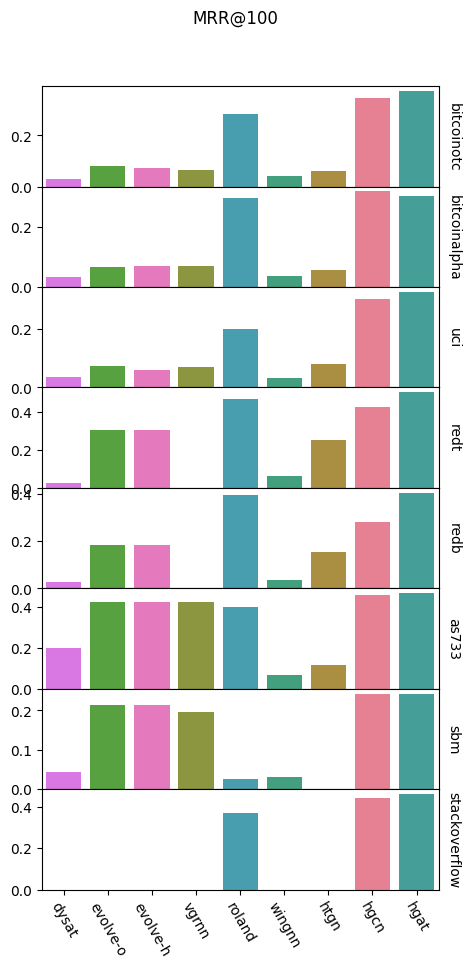

In [6]:
hue_order = [
    'dysat', 'evolve-o', 'evolve-h', 'vgrnn', 'roland', 'wingnn', 'htgn', 'hgcn', 'hgat',
]
row_order = ['bitcoinotc', 'bitcoinalpha', 'uci', 'redt', 'redb', 'as733', 'sbm', 'stackoverflow']
g1 = sbn.FacetGrid(df.query('type == "main"'), row="dataset", sharey=False, sharex=False, hue='model', 
                  aspect=4, height=1.2, margin_titles=True, despine=False, row_order=row_order)
g1.map_dataframe(sbn.barplot, x="model", y="mrr_mean", order=hue_order)

for i, axes in enumerate(g1.axes.flat):
    axes.set_ylabel('')
    if i+1 < len(row_order):
        axes.set_xticklabels([])
    else:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)
g1.set_titles(col_template="{col_name}", row_template="{row_name}")
#g1.set_ylabels("MRR@1000")
g1.figure.subplots_adjust(wspace=0, hspace=0)
g1.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
g1.fig.suptitle('MRR@100')
g1.set_xlabels("")

In [7]:
'dysat', 'evolve-o', 'evolve-h', 'vgrnn', 'roland', 'wingnn', 'htgn', 'hgcn', 'hgat',
b_map = {
    'dysat': '\\texttt{DySAT}',
    'evolve-h': '\\texttt{EvolveGCN-h}',
    'evolve-o': '\\texttt{EvolveGCN-o}',
    'vgrnn': '\\texttt{VGRNN}',
    'htgn': '\\texttt{HTGN}',
    'wingnn': '\\texttt{WinGNN}',
    'roland': '\\texttt{Roland}',
    'hgcn': '\\texttt{SFDyG-GCN}',
    'hgat': '\\texttt{SFDyG-GAT}',
}
sf=df.query('type == "main"')
mrr_table = []
for model in hue_order:
    mrr_list = []
    for ds in row_order:
        order = sf.query(f'dataset == "{ds}" and model in {hue_order}').sort_values(by='mrr_mean', ascending=False).reset_index()
        rank = {}
        for i, row in order.iterrows():
            rank[row['model']] = i
         
        record = sf.query(f'model == "{model}" and dataset == "{ds}"')
        if len(record) == 0:
            mrr_list.append('OOM.')
        else:
            val = f"{record['mrr_mean'].values[0]*100:.2f} $\pm$ {record['mrr_std'].values[0]*100:.2f}"
            if rank[model] == 0:
                mrr_list.append("\\textbf{" + val + "}")
            elif rank[model] == 1:
                mrr_list.append("\\underline{" + val + "}")
            else:
                mrr_list.append(val)
    mrr_table.append(b_map[model] + '   &' + ' & '.join(mrr_list) + '    \\\\')
    print(mrr_table[-1])


\texttt{DySAT}   &3.00 $\pm$ 0.68 & 3.33 $\pm$ 1.79 & 3.72 $\pm$ 1.59 & 2.86 $\pm$ 0.47 & 2.85 $\pm$ 1.06 & 19.92 $\pm$ 0.74 & 4.28 $\pm$ 1.57 & OOM.    \\
\texttt{EvolveGCN-o}   &7.90 $\pm$ 0.15 & 6.66 $\pm$ 0.44 & 7.22 $\pm$ 0.05 & 30.47 $\pm$ 0.24 & 18.45 $\pm$ 0.02 & 42.06 $\pm$ 0.00 & 21.38 $\pm$ 0.00 & OOM.    \\
\texttt{EvolveGCN-h}   &7.08 $\pm$ 0.10 & 6.82 $\pm$ 0.37 & 6.04 $\pm$ 1.70 & 30.64 $\pm$ 0.02 & 18.46 $\pm$ 0.02 & 42.06 $\pm$ 0.00 & 21.38 $\pm$ 0.00 & OOM.    \\
\texttt{VGRNN}   &6.60 $\pm$ 0.33 & 6.84 $\pm$ 0.28 & 7.05 $\pm$ 0.15 & OOM. & OOM. & 42.38 $\pm$ 0.79 & 19.70 $\pm$ 0.53 & OOM.    \\
\texttt{Roland}   &28.25 $\pm$ 0.51 & 29.41 $\pm$ 0.68 & 19.85 $\pm$ 2.40 & \underline{46.77 $\pm$ 0.37} & \underline{39.29 $\pm$ 0.40} & 39.80 $\pm$ 5.24 & 2.70 $\pm$ 1.05 & 37.16 $\pm$ 0.07    \\
\texttt{WinGNN}   &4.07 $\pm$ 0.85 & 3.73 $\pm$ 0.87 & 3.10 $\pm$ 0.81 & 6.26 $\pm$ 0.76 & 3.55 $\pm$ 1.17 & 6.93 $\pm$ 1.59 & 3.21 $\pm$ 0.17 & OOM.    \\
\texttt{HTGN}   &5.99 $\p

In [8]:
for met in ['hit@1', 'hit@3', 'hit@10']:
    print(met)
    for model in hue_order:
        mrr_list = []
        for ds in row_order:
            order = sf.query(f'dataset == "{ds}" and model in {hue_order}').sort_values(by=f'{met}_mean', ascending=False).reset_index()
            rank = {}
            for i, row in order.iterrows():
                rank[row['model']] = i
             
            record = sf.query(f'model == "{model}" and dataset == "{ds}"')
            if len(record) == 0:
                mrr_list.append('OOM.')
            else:
                val = f"{record[f'{met}_mean'].values[0]*100:.2f} $\pm$ {record[f'{met}_std'].values[0]*100:.2f}"
                if rank[model] == 0:
                    mrr_list.append("\\textbf{" + val + "}")
                elif rank[model] == 1:
                    mrr_list.append("\\underline{" + val + "}")
                else:
                    mrr_list.append(val)
        line = b_map[model] + '   &' + ' & '.join(mrr_list) + '    \\\\'
        print(line)

hit@1
\texttt{DySAT}   &0.18 $\pm$ 0.25 & 1.03 $\pm$ 1.31 & 0.27 $\pm$ 0.21 & 0.82 $\pm$ 0.44 & 0.20 $\pm$ 0.21 & 17.72 $\pm$ 0.50 & 0.77 $\pm$ 0.61 & OOM.    \\
\texttt{EvolveGCN-o}   &2.61 $\pm$ 0.18 & 2.54 $\pm$ 0.54 & 2.87 $\pm$ 0.00 & 26.22 $\pm$ 0.58 & 13.69 $\pm$ 0.01 & \textbf{35.70 $\pm$ 0.00} & 16.14 $\pm$ 0.00 & OOM.    \\
\texttt{EvolveGCN-h}   &2.28 $\pm$ 0.08 & 2.67 $\pm$ 0.29 & 1.95 $\pm$ 1.31 & 26.64 $\pm$ 0.07 & 13.69 $\pm$ 0.01 & \underline{35.70 $\pm$ 0.00} & 16.14 $\pm$ 0.00 & OOM.    \\
\texttt{VGRNN}   &1.99 $\pm$ 0.20 & 2.28 $\pm$ 0.49 & 2.92 $\pm$ 0.10 & OOM. & OOM. & 33.54 $\pm$ 1.18 & 14.25 $\pm$ 0.63 & OOM.    \\
\texttt{Roland}   &14.10 $\pm$ 0.47 & 14.81 $\pm$ 1.16 & 8.17 $\pm$ 2.30 & \underline{33.73 $\pm$ 0.25} & \underline{26.71 $\pm$ 0.41} & 27.36 $\pm$ 5.44 & 0.03 $\pm$ 0.04 & 24.04 $\pm$ 0.31    \\
\texttt{WinGNN}   &0.58 $\pm$ 0.29 & 0.34 $\pm$ 0.09 & 0.10 $\pm$ 0.10 & 2.04 $\pm$ 0.65 & 1.03 $\pm$ 0.87 & 3.85 $\pm$ 0.82 & 1.04 $\pm$ 0.26 & OOM.    \\

# Main GPU usage

/home/qqg/miniconda3/envs/zoo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/qqg/miniconda3/envs/zoo/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


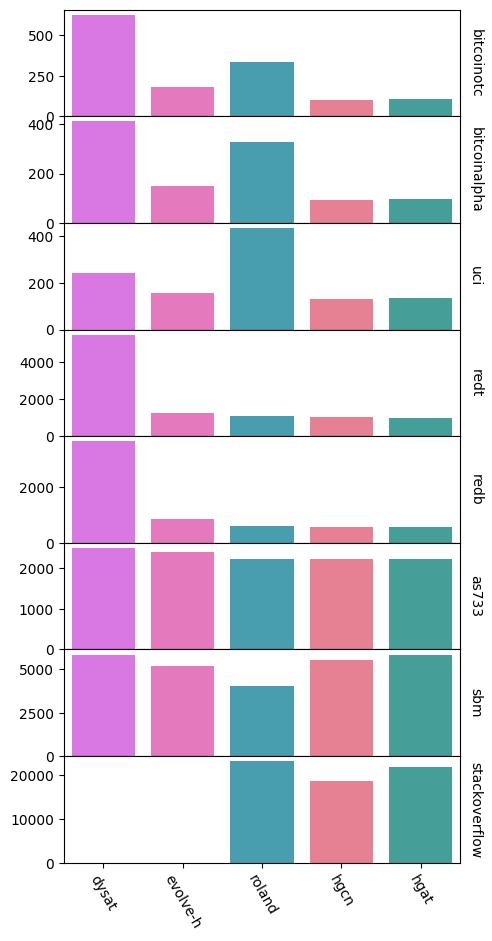

In [9]:

hue_order = [
    'dysat', 'evolve-h',  'roland', 'hgcn', 'hgat',
]

g1 = sbn.FacetGrid(df.query('type == "main"'), row="dataset", sharey=False, sharex=False, hue='model', 
                  aspect=4, height=1.2, margin_titles=True, despine=False, row_order=row_order)
g1.map_dataframe(sbn.barplot, x="model", y="gpu_mem", order=hue_order)

for i, axes in enumerate(g1.axes.flat):
    axes.set_ylabel('')
    if i+1 < df.dataset.nunique():
        axes.set_xticklabels([])
    else:
        _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=-60)
g1.set_titles(col_template="{col_name}", row_template="{row_name}")
#g1.set_ylabels("GPU Mem(M)")
#g1.fig.suptitle('GPU Mem (MB)')
g1.figure.subplots_adjust(wspace=0, hspace=0)
g1.set_xlabels("")

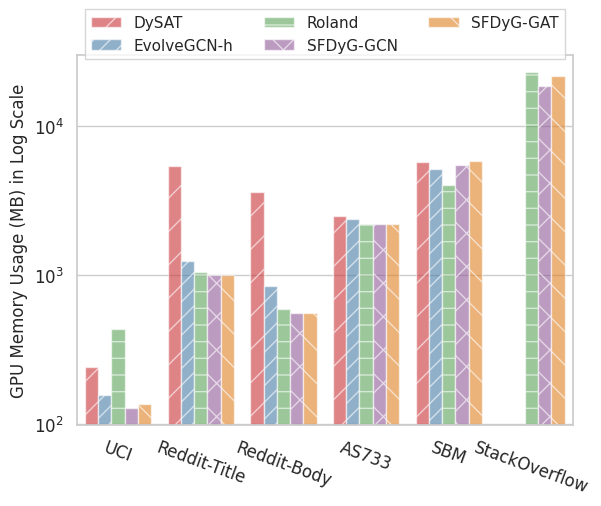

In [56]:
# https://stackoverflow.com/questions/42185000/add-hash-pattern-to-a-seaborn-bar-plot
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

hue_order = [
    'dysat', 'evolve-h',  'roland', 'hgcn', 'hgat',
]

row_order = ['uci', 'redt', 'redb', 'as733', 'sbm', 'stackoverflow']


ax = sbn.barplot(
    data=df.query(f'type == "main" and model in {hue_order} and dataset in {row_order}').sort_values(by='dataset'),
    x="dataset", y="gpu_mem", hue="model", hue_order=hue_order, order=row_order,
    errorbar="sd", alpha=.6, palette='Set1'
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=-30)
ax.set_xticklabels(['UCI','Reddit-Title', 'Reddit-Body', 'AS733', 'SBM', 'StackOverflow'], rotation=-20)


num_locations = len(row_order)
hatches = itertools.cycle(['/', '//', '-', 'x', '\\', '+','*', 'o', 'O', '.'])
for i, bar in enumerate(ax.patches):
    if i % num_locations == 0:
        hatch = next(hatches)
    bar.set_hatch(hatch)

    
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.145), ncol=3, fancybox=False, shadow=False)
new_labels = ['DySAT', 'EvolveGCN-h', 'Roland', 'SFDyG-GCN', 'SFDyG-GAT']
for t, l in zip(ax.get_legend().get_texts(), new_labels):
    t.set_text(l)
    
ax.set_xlabel("")
ax.set_ylabel("GPU Memory Usage (MB) in Log Scale")
plt.yscale('log')
plt.yticks( size = 12)
plt.xticks( size = 12)
plt.savefig('gpu_usage.pdf', format='pdf', dpi=360)

# Mini-batch

In [108]:
df.dataset.unique()


array(['as733', 'uci', 'redt', 'redb', 'sbm', 'bitcoinalpha',
       'bitcoinotc', 'stackoverflow'], dtype=object)

In [116]:
model = [
    'hgcn', 'hgat'
]
row_order = ['bitcoinotc', 'bitcoinalpha', 'uci', 'redt', 'redb',  'stackoverflow', 'as733', 'sbm',]
b_map = {
    'dysat': '\\texttt{DySAT}',
    'evolve-h': '\\texttt{EvolveGCN-h}',
    'evolve-o': '\\texttt{EvolveGCN-o}',
    'vgrnn': '\\texttt{VGRNN}',
    'htgn': '\\texttt{HTGN}',
    'wingnn': '\\texttt{WinGNN}',
    'roland': '\\texttt{Roland}',
    'hgcn': '\\texttt{SFDyG-GCN}',
    'hgat': '\\texttt{SFDyG-GAT}',
}
d_map = {
    'as733': 'AS733',
    'redt': 'Reddit-Title', 
    'redb': 'Reddit-Body', 
    'bitcoinalpha': 'Alpha', 
    'bitcoinotc': 'OTC', 
    'sbm': 'SBM',
    'uci': 'UCI', 
    'stackoverflow': 'SO'
}
types = ["main", 'mini']
sf=df.query(f'type in {types} and model in {model}')
mrr_table = []
# for model in hue_order:
#     print(model)
for ds in row_order[:-2]:
    fb = sf.query(f'model == "{model[0]}" and dataset == "{ds}" and type == "main"')
    mb = sf.query(f'model == "{model[0]}" and dataset == "{ds}" and type == "mini"')
    fb_avg = fb['mrr_mean'].values[0]
    mb_avg = mb['mrr_mean'].values[0]

    # fb_val = f"{fb_avg*100:.2f} $\pm$ {fb_std*100:.2f}"
    # mb_val = f"{mb_avg*100:.2f} $\pm$ {mb_std*100:.2f}"
    fb_val = f"{fb_avg*1:.4f}"
    mb_val = f"{mb_avg*1:.4f}"
    mrr_delta = np.abs(fb_avg - mb_avg) / fb_avg * 100
    
    fb_mem = fb['gpu_mem'].values[0]
    mb_mem = mb['gpu_mem'].values[0]
    mem_delta = np.abs(fb_mem - mb_mem) / fb_mem * 100
    
    sign1 = '\\downarrow' if fb_avg > mb_avg else '\\uparrow'
    sign2 = '\\downarrow' if fb_mem > mb_mem else '\\uparrow'
    #mrr_table.append(d_map[ds] + '   &' + fb_val + '  &  ' +  mb_val + '  &  ' + f'${sign}$ {delta:.2f}' + '    \\\\')
    gcn_str = f'{fb_val}  &  {mb_val}  & ${sign1}$ {mrr_delta:.2f}\\%  & ${sign2}$ {mem_delta:.2f}\\%'


    fb = sf.query(f'model == "{model[1]}" and dataset == "{ds}" and type == "main"')
    mb = sf.query(f'model == "{model[1]}" and dataset == "{ds}" and type == "mini"')
    fb_avg = fb['mrr_mean'].values[0]
    mb_avg = mb['mrr_mean'].values[0]

    # fb_val = f"{fb_avg*100:.2f} $\pm$ {fb_std*100:.2f}"
    # mb_val = f"{mb_avg*100:.2f} $\pm$ {mb_std*100:.2f}"
    fb_val = f"{fb_avg*1:.4f}"
    mb_val = f"{mb_avg*1:.4f}"
    mrr_delta = np.abs(fb_avg - mb_avg) / fb_avg * 100
    
    fb_mem = fb['gpu_mem'].values[0]
    mb_mem = mb['gpu_mem'].values[0]
    mem_delta = np.abs(fb_mem - mb_mem) / fb_mem * 100
    
    sign1 = '\\downarrow' if fb_avg > mb_avg else '\\uparrow'
    sign2 = '\\downarrow' if fb_mem > mb_mem else '\\uparrow'
    gat_str = f'{fb_val}  &  {mb_val}  & ${sign1}$ {mrr_delta:.2f}\\%  & ${sign2}$ {mem_delta:.2f}\\%'
    
    mrr_table.append(f'{d_map[ds]} & {gcn_str}  & {gat_str}  \\\\')
    print(mrr_table[-1])


OTC & 0.3447  &  0.3620  & $\uparrow$ 5.02\%  & $\downarrow$ 28.03\%  & 0.3737  &  0.3632  & $\downarrow$ 2.81\%  & $\downarrow$ 33.65\%  \\
Alpha & 0.3177  &  0.3324  & $\uparrow$ 4.63\%  & $\downarrow$ 43.23\%  & 0.3033  &  0.3243  & $\uparrow$ 6.92\%  & $\downarrow$ 42.87\%  \\
UCI & 0.3019  &  0.3253  & $\uparrow$ 7.75\%  & $\downarrow$ 50.03\%  & 0.3258  &  0.3326  & $\uparrow$ 2.09\%  & $\downarrow$ 49.18\%  \\
Reddit-Title & 0.4267  &  0.4062  & $\downarrow$ 4.80\%  & $\downarrow$ 0.16\%  & 0.5044  &  0.4716  & $\downarrow$ 6.50\%  & $\downarrow$ 0.13\%  \\
Reddit-Body & 0.2795  &  0.2979  & $\uparrow$ 6.58\%  & $\downarrow$ 0.50\%  & 0.4046  &  0.4042  & $\downarrow$ 0.10\%  & $\downarrow$ 0.48\%  \\
SO & 0.4425  &  0.4347  & $\downarrow$ 1.76\%  & $\downarrow$ 36.02\%  & 0.4613  &  0.4652  & $\uparrow$ 0.85\%  & $\downarrow$ 30.35\%  \\


In [115]:
df.query(f'type in {types} and model in {model} and dataset == "stackoverflow"')

,dataset,model,gpu_mem,epoch_time,train_time,mrr_mean,hit@1_mean,hit@3_mean,hit@10_mean,mrr_std,hit@1_std,hit@3_std,hit@10_std,type,exp_name,exp_param
32,stackoverflow,hgcn,11983.39,738.94,15517.72,0.4347,0.3106,0.4779,0.7330,0.0000,0.0000,0.0000,0.0000,mini,,0.0
48,stackoverflow,hgat,15286.39,727.91,24021.05,0.4652,0.3480,0.5122,0.7242,0.0000,0.0000,0.0000,0.0000,mini,,0.0
132,stackoverflow,hgat,21946.59,121.56,4943.37,0.4613,0.3353,0.5202,0.7315,0.0005,0.0007,0.0020,0.0003,main,,0.0
144,stackoverflow,hgcn,18730.34,223.92,9479.48,0.4425,0.3256,0.4799,0.7163,0.0010,0.0012,0.0013,0.0009,main,,0.0


# Ablation

In [118]:
hue_order = ['gcn', 'hgat']
row_order = ['bitcoinotc', 'bitcoinalpha', 'uci', 'redt', 'redb', 'as733', 'sbm', 'stackoverflow']
sf=df.query(f'(type == "main") and model in {hue_order}') #  or (type == "exp" and exp_name == "nobn")
sf.sort_values(by=["dataset", "model"])[['dataset', 'model', 'mrr_mean', 'mrr_std', 'type', 'exp_name']]

,dataset,model,mrr_mean,mrr_std,type,exp_name
91,as733,gcn,0.4799,0.0052,main,
15,as733,hgat,0.4653,0.0049,main,
80,bitcoinalpha,gcn,0.3505,0.0045,main,
25,bitcoinalpha,hgat,0.3033,0.0105,main,
131,bitcoinotc,gcn,0.3855,0.0009,main,
111,bitcoinotc,hgat,0.3737,0.0010,main,
140,redb,gcn,0.3549,0.0132,main,
67,redb,hgat,0.4046,0.0053,main,
110,redt,gcn,0.4786,0.0065,main,
50,redt,hgat,0.5044,0.0016,main,


In [100]:
for ds in row_order:
    gat = sf.query(f'model == "gat" and dataset == "{ds}"')
    hgat = sf.query(f'model == "hgat" and dataset == "{ds}"')
    gat_avg = gat['mrr_mean'].values[0]
    hgat_avg = hgat['mrr_mean'].values[0]
    gat_std = gat['mrr_std'].values[0]
    hgat_std = hgat['mrr_std'].values[0]

    gat_val = f"{gat_avg*100:.2f} $\pm$ {gat_std*100:.2f}"
    hgat_val = f"{hgat_avg*100:.2f} $\pm$ {hgat_std*100:.2f}"

    delta = (hgat_avg - gat_avg) / gat_avg * 100
    row_str = f'{d_map[ds]} &  {gat_val}  &  {hgat_val}  & {delta:.2f}\\%  \\\\'
    print(row_str)
    

OTC &  27.80 $\pm$ 0.58  &  37.37 $\pm$ 0.10  & 34.42\%  \\
Alpha &  26.64 $\pm$ 0.34  &  30.33 $\pm$ 1.05  & 13.85\%  \\
UCI &  15.25 $\pm$ 1.00  &  32.58 $\pm$ 1.02  & 113.64\%  \\
Reddit-Title &  18.13 $\pm$ 0.34  &  50.44 $\pm$ 0.16  & 178.21\%  \\
Reddit-Body &  14.86 $\pm$ 1.01  &  40.46 $\pm$ 0.53  & 172.27\%  \\
AS733 &  12.97 $\pm$ 1.05  &  46.53 $\pm$ 0.49  & 258.75\%  \\
SBM &  8.67 $\pm$ 6.88  &  24.02 $\pm$ 4.55  & 177.05\%  \\
SO &  25.60 $\pm$ 1.29  &  46.13 $\pm$ 0.05  & 80.20\%  \\


# Hyper parameter

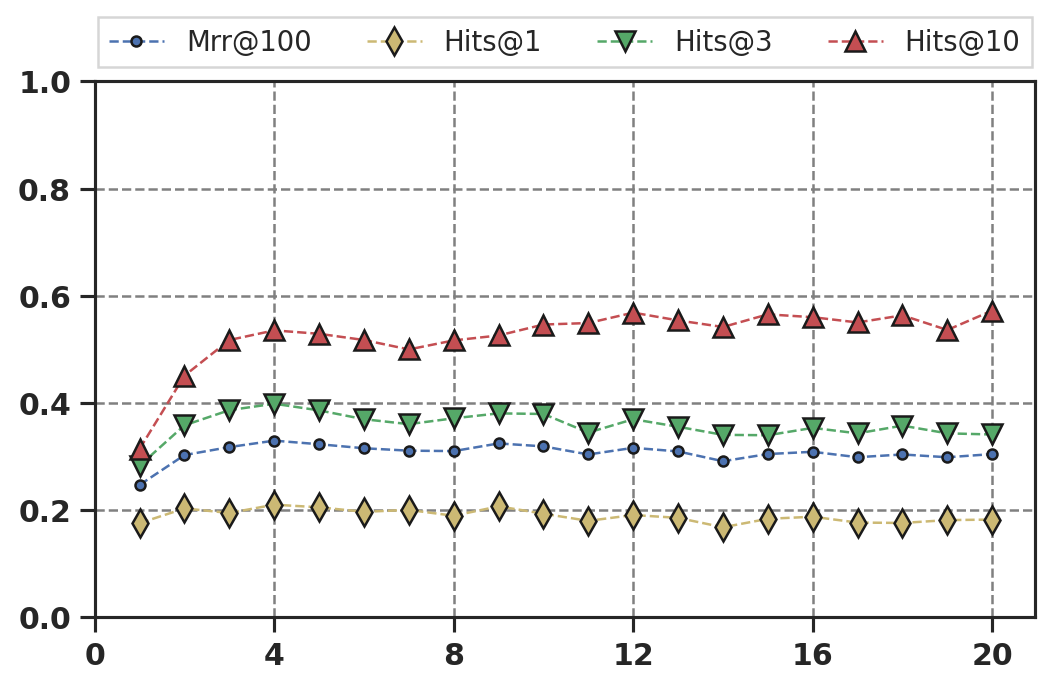

In [147]:
import matplotlib.pyplot as plt
sf = df[(df.type=='exp') & (df.exp_name=='window')].sort_values(by='exp_param').reset_index()
custom_params = {"grid.linewidth":1, 'grid.color': 'gray', 'grid.linestyle': '--'}
sns.set_theme(style="ticks", rc=custom_params)
plt.figure(figsize=(6.2, 4), dpi=180)
plt.plot(sf.exp_param-1, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='Mrr@100')
plt.plot(sf.exp_param-1, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(sf.exp_param-1, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(sf.exp_param-1, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend(bbox_to_anchor=(1,0.7), loc="upper left", fontsize=14)
ax = plt.gca()
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.145), ncol=4, fancybox=False, shadow=False)
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(0, 21, 4))
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
plt.tight_layout()
plt.savefig('hp_win.pdf', format='pdf', dpi=360)

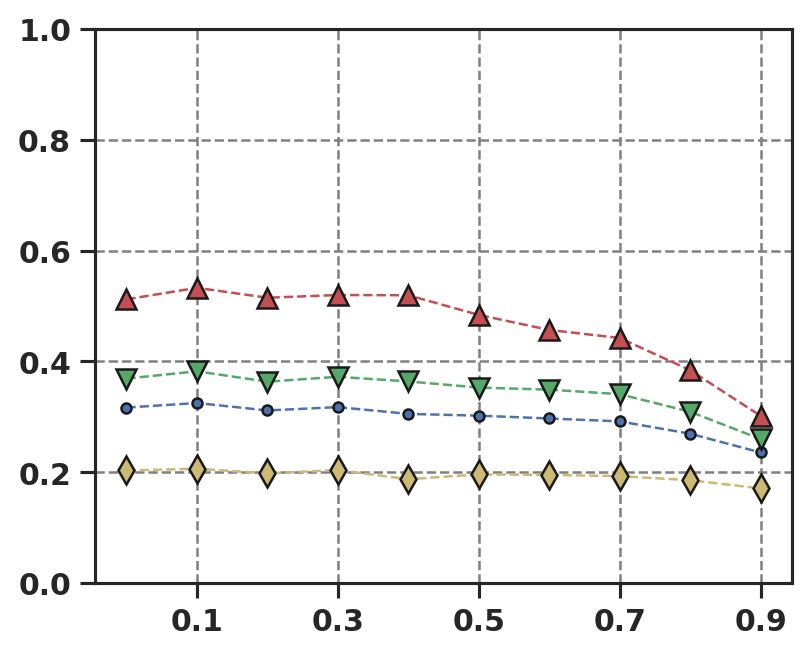

In [50]:
sf = df[(df.type=='exp') & (df.exp_name=='dropout')].sort_values(by='exp_param').reset_index()
plt.figure(figsize=(5, 4), dpi=180)
plt.plot(sf.exp_param*0.1, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='MRR@100')
plt.plot(sf.exp_param*0.1, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(sf.exp_param*0.1, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(sf.exp_param*0.1, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend()
ax = plt.gca()
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticks(np.arange(0.1, 1, 0.2))
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
plt.savefig('hp_dropout.pdf', format='pdf', dpi=360)

/tmp/ipykernel_239747/2203623168.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0, 1,2,4,8,16])


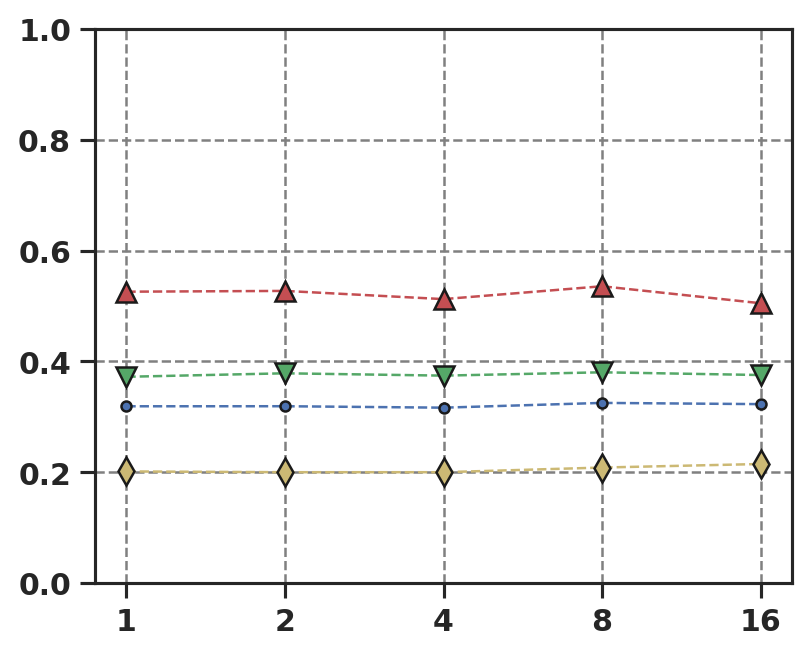

In [49]:
sf = df[(df.type=='exp') & (df.exp_name=='heads')].sort_values(by='exp_param').reset_index()
plt.figure(figsize=(5, 4), dpi=180)
xvals = range(1, len(sf)+1)
plt.plot(xvals, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='MRR@100')
plt.plot(xvals, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(xvals, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(xvals, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend()
ax = plt.gca()
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticklabels([0, 1,2,4,8,16]) 
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
plt.savefig('hp_heads.pdf', format='pdf', dpi=360)

/tmp/ipykernel_239747/3376847025.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i) for i in [0] + sf.exp_param.to_list()])


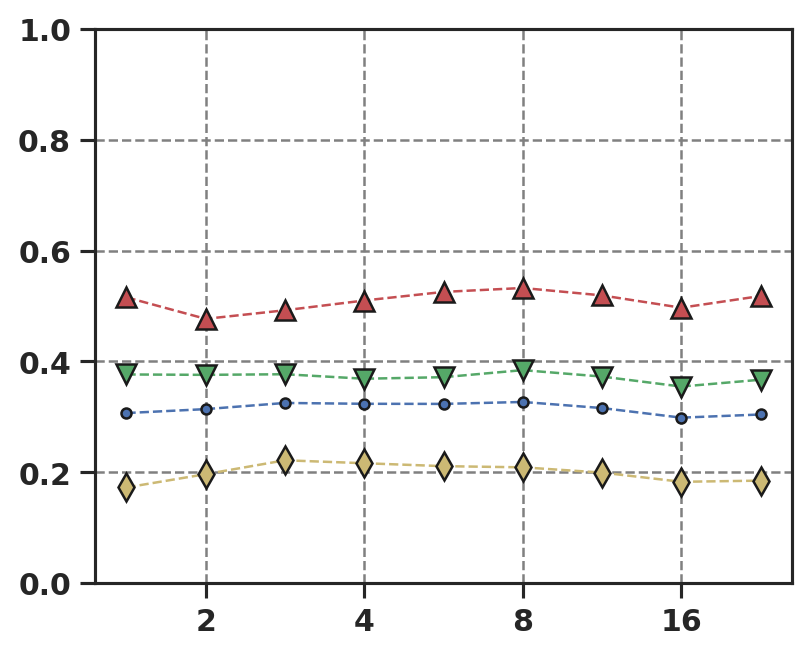

In [144]:
sf = df[(df.type=='exp') & (df.exp_name=='hidden')].sort_values(by='exp_param').reset_index()
plt.figure(figsize=(5, 4), dpi=180)
xvals = range(1, len(sf)+1)
plt.plot(xvals, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='MRR@100')
plt.plot(xvals, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(xvals, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(xvals, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend()
ax = plt.gca()
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticklabels([int(i) for i in [0] + sf.exp_param.to_list()]) 
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
plt.savefig('hp_hidden.pdf', format='pdf', dpi=360)

/tmp/ipykernel_239747/3818598184.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['0', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1'])


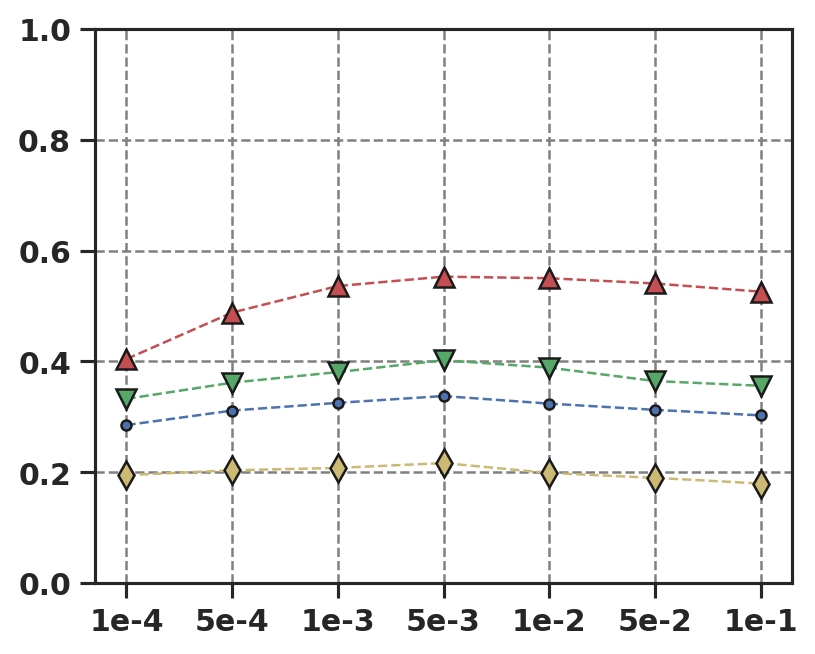

In [136]:
import matplotlib.pyplot as plt
custom_params = {"grid.linewidth":1, 'grid.color': 'gray', 'grid.linestyle': '--'}
sns.set_theme(style="ticks", rc=custom_params)
#plt.figure(figsize=(6.2, 4), dpi=180)

sf = df[(df.type=='exp') & (df.exp_name=='learnrate')].sort_values(by='exp_param').reset_index()
plt.figure(figsize=(5, 4), dpi=180)
xvals = range(1, len(sf)+1)
plt.plot(xvals, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='MRR@100')
plt.plot(xvals, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(xvals, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(xvals, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend()
ax = plt.gca()
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticklabels(['0', '1e-4', '5e-4', '1e-3', '5e-3', '1e-2', '5e-2', '1e-1']) 
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
plt.savefig('hp_lr.pdf', format='pdf', dpi=360)

/tmp/ipykernel_239747/2953571345.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([int(i) for i in [0] + sf.exp_param.to_list()])


(array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 [Text(0.0, 0, '0'),
  Text(1.0, 0, '1'),
  Text(2.0, 0, '2'),
  Text(3.0, 0, '5'),
  Text(4.0, 0, '10'),
  Text(5.0, 0, '20'),
  Text(6.0, 0, '30'),
  Text(7.0, 0, '40'),
  Text(8.0, 0, '50'),
  Text(9.0, 0, '')])

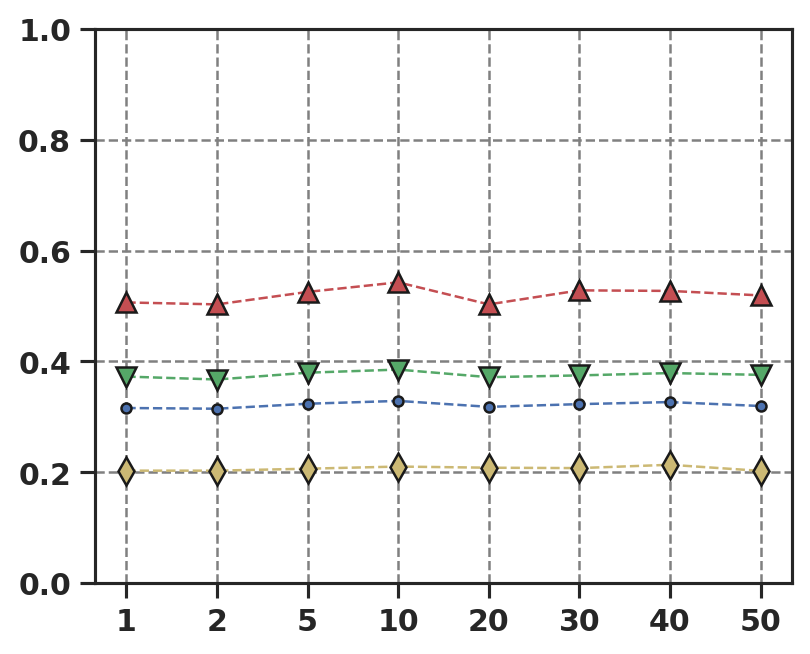

In [140]:
import matplotlib.pyplot as plt
custom_params = {"grid.linewidth":1, 'grid.color': 'gray', 'grid.linestyle': '--'}
sns.set_theme(style="ticks", rc=custom_params)
#plt.figure(figsize=(6.2, 4), dpi=180)

sf = df[(df.type=='exp') & (df.exp_name=='n_neg_train')].sort_values(by='exp_param').reset_index()
plt.figure(figsize=(5, 4), dpi=180)
xvals = range(1, len(sf)+1)
plt.plot(xvals, sf.mrr_mean, linestyle='--', linewidth=1, marker='.', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='b', label='MRR@100')
plt.plot(xvals, sf['hit@1_mean'], linestyle='--', linewidth=1, marker='d',  
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='y', label='Hits@1')
plt.plot(xvals, sf['hit@3_mean'], linestyle='--', linewidth=1, marker='v', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='g', label='Hits@3')
plt.plot(xvals, sf['hit@10_mean'], linestyle='--', linewidth=1, marker='^', 
         markeredgecolor="k", markeredgewidth=1, markersize=8, color='r', label='Hits@10')
#plt.legend()
ax = plt.gca()
plt.grid()
ax.set_ylim([0, 1])
ax.set_xticklabels([int(i) for i in [0] + sf.exp_param.to_list()]) 
plt.yticks(weight='bold', size = 12)
plt.xticks(weight='bold', size = 12)
#plt.savefig('hp_ktrain.pdf', format='pdf', dpi=360)